This is a tutorial notebook on object-oriented software design, prepared for the Foundations of Software Engineering (FSE v2020.1, https://github.com/adasegroup/FSE2020_seminars) at Skoltech (http://skoltech.ru).

Copyright 2020 by Alexey Artemov and ADASE Lab. 

# FSE-08: Object-Oriented Software Design: Behavioral Design Patterns

## 1. State: change behavior when changing internal state

When you need to represent an object that may be in a number of distinct states, as if there were a variety of different objects.

**Why would we like to have a stateful object?**

Acceptable reasons to use a State pattern include:

 - Access to a "heavy" shared resource (e.g. a database), preferred that an access to the resource will be requested from multiple, disparate parts of the system.
 - "Logging class rationale": heavy re-use of the same class instance by lots of callers 
 > A Singleton can be used instead of a single instance of a class because a logging class usually needs to be used over and over again ad nauseam by every class in a project. If every class uses this logging class, dependency injection becomes cumbersome. ([When should I use the singleton?](https://stackoverflow.com/questions/228164/on-design-patterns-when-should-i-use-the-singleton))
 
 

**Example implementation:**


```python
class ATMMachine:
    def __init__(self, amount):
        self._amount = amount
        self._state = NoCash(self) if amount == 0 else Working(self)
    
    def set_state(self, state):
        self._state = state
        
    def get_amount(self): 
        return self._amount
    
    def set_amount(self, amount):
        self._amount = amount
    
    def withdraw(self, amount):
        self._state.withdraw(amount)
    
    def refill(self, amount):
        self._state.refill(amount)


from abc import ABC, abstractmethod

class State(ABC):
    def __init__(self, atm):
        self._atm = atm

    @abstractmethod
    def withdraw(self, amount):
        pass
    
    @abstractmethod
    def refill(self, amount):
        pass


class NoCash(State):
    def withdraw(self, amount):
        print('no cash')
    
    def refill(self, amount):
        self._atm.set_amount(self._atm.get_amount() + amount)
        self._atm.set_state(
            Working(self._atm)
        )


class Working(State):
    def withdraw(self, amount):
        if 0 < self._atm.get_amount() <= amount:
            amount_to_withdraw = amount - self._atm.get_amount()
        else:
            amount_to_withdraw = amount
        
        self._atm.set_amount(self._atm.get_amount() - amount_to_withdraw)
        if self._atm.get_amount() == 0:
            self._atm.set_state(
                NoCash(self._atm)
            )

    def refill(self, amount):
        self._atm.set_amount(self._atm.get_amount() + amount)

            
# Usage:
model = ATM(amount=1000)
model.withdraw(500)
model.withdraw(500)  # State -> NoCash
model.withdraw(100)
model.refill(100)    # State -> Working again
```

**Task:** 
1. Explain where can a State pattern be used within the virus spread modelling system.
2. Implement a State pattern with the Person class, modeling the infection/recovery chain.

In [10]:
class Person:
    MAX_TEMPERATURE_TO_SURVIVE = 44.0
    LOWEST_WATER_PCT_TO_SURVIVE = 0.4
    
    LIFE_THREATENING_TEMPERATURE = 40.0
    LIFE_THREATENING_WATER_PCT = 0.5
    
    def __init__(self, home_position=(0, 0), age=30, weight=70):
        self.virus = None
        self.antibody_types = set()
        self.temperature = 36.6
        self.weight = weight
        self.water = 0.6 * self.weight
        self.age = age
        self.home_position = home_position
        self.position = home_position
        self.state = Healthy(self)
    
    def day_actions(self):
        self.state.day_actions()

    def night_actions(self):
        self.state.night_actions()

    def interact(self, other):
        self.state.interact(other)

    def get_infected(self, virus):
        self.state.get_infected(virus)
    
    def is_close_to(self, other):
        return self.position == other.position
    
    def fightvirus(self):
        if self.virus:
            self.virus.strength -= (3.0 / self.age)
        
    def progress_disease(self):
        if self.virus:
            self.virus.cause_symptoms(self)

    def set_state(self, state):
        self.state = state
    
    def is_life_threatening_condition(self):
        return self.temperature >= Person.LIFE_THREATENING_TEMPERATURE or \
            self.water / self.weight <= Person.LIFE_THREATENING_WATER_PCT
    
    def is_life_incompatible_condition(self):        
        return self.temperature >= Person.MAX_TEMPERATURE_TO_SURVIVE or \
            self.water / self.weight <= Person.LOWEST_WATER_PCT_TO_SURVIVE

In [11]:
from enum import Enum
from abc import ABC, abstractmethod
from random import expovariate, uniform, randint

class Infectable(ABC):
    def __init__(self, strength=1.0, contag=1.0):
        # contag is for contagiousness so we have less typos
        self.strength = strength
        self.contag = contag

    @abstractmethod
    def cause_symptoms(self, person):
        pass
    
    
class SeasonalFluVirus(Infectable):
    def cause_symptoms(self, person):
        person.temperature += 0.25

    def get_type(self):
        return InfectableType.SeasonalFlu
    
    
class SARSCoV2(Infectable):
    def cause_symptoms(self, person):
        person._temperature += 0.5

    def get_type(self):
        return InfectableType.SARSCoV2


class Cholera(Infectable):
    def cause_symptoms(self, person):
        person.water -= 1.0

    def get_type(self):
        return InfectableType.Cholera
    

class InfectableType(Enum):
    SeasonalFlu = 1
    SARSCoV2 = 2
    Cholera = 3

    
def get_infectable(infectable_type: InfectableType):
    if InfectableType.SeasonalFlu == infectable_type:
        return SeasonalFluVirus(strength=expovariate(10.0), contag=expovariate(10.0))
    
    elif InfectableType.SARSCoV2 == infectable_type:
        return SARSCoV2(strength=expovariate(2.0), contag=expovariate(2.0))
    
    elif InfectableType.Cholera == infectable_type:
        return Cholera(strength=expovariate(2.0), contag=expovariate(2.0))
    
    else:
        raise ValueError()

In [3]:
class DepartmentOfHealth:
    def __init__(self):
        pass
    
    def monitor_situation(self):
        pass
    
    def issue_policy(self):
        pass
    
    def hospitalize(self, person):
        print('hospitalization')
        pass

In [4]:
from abc import ABC, abstractmethod


min_i, max_i = 0, 100
min_j, max_j = 0, 100
    

class State(ABC):
    def __init__(self, person): 
        self.person = person
        
    @abstractmethod
    def day_actions(self): pass

    @abstractmethod
    def night_actions(self): pass

    @abstractmethod
    def interact(self, other): pass

    @abstractmethod
    def get_infected(self, virus): pass


class Healthy(State):
    def day_actions(self):
        # different for CommunityPerson?!
        self.person.position = (randint(min_j, max_j), randint(min_i, max_i))

    def night_actions(self):
        self.person.position = self.person.home_position

    def interact(self, other: Person): pass

    def get_infected(self, virus):
        if virus.get_type() not in self.person.antibody_types:
            self.person.virus = virus
            self.person.set_state(AsymptomaticSick(self.person))


class AsymptomaticSick(State):
    DAYS_SICK_TO_FEEL_BAD = 2
    
    def __init__(self, person):
        super().__init__(person)
        self.days_sick = 0

    def day_actions(self):
        # different for CommunityPerson?!
        self.person.position = (randint(min_j, max_j), randint(min_i, max_i))

    def night_actions(self):
        self.person.position = self.person.home_position
        if self.days_sick == AsymptomaticSick.DAYS_SICK_TO_FEEL_BAD:
            self.person.set_state(SymptomaticSick(self.person))
        self.days_sick += 1

    def interact(self, other):
        other.get_infected(self.person.virus)

    def get_infected(self, virus): pass


class SymptomaticSick(State):
    def day_actions(self):
        self.person.progress_disease()
        
        if self.person.is_life_threatening_condition():
            health_dept = DepartmentOfHealth()
            health_dept.hospitalize(self.person)

        if self.person.is_life_incompatible_condition():
            self.person.set_state(Dead(self.person))
        
    def night_actions(self):
        # try to fight the virus
        self.person.fightvirus()
        if self.person.virus.strength <= 0:
            self.person.set_state(Healthy(self.person))
            self.person.antibody_types.add(self.person.virus.get_type())
            self.person.virus = None

    def interact(self, other): pass

    def get_infected(self, virus): pass

    
class Dead(State):
    def day_actions(self): pass

    def night_actions(self): pass

    def interact(self, other): pass

    def get_infected(self, virus): pass


In [41]:
p = Person(age=40, weight=80)

In [42]:
p.get_infected(SeasonalFluVirus(strength=1.0))

In [34]:
for day in range(60):
    p.day_actions()
    p.night_actions()
    print(day, p.temperature, p.water, p.state, p.virus.strength if p.virus else None)

0 36.6 48.0 <__main__.AsymptomaticSick object at 0x7f0660094400> 1.0
1 36.6 48.0 <__main__.AsymptomaticSick object at 0x7f0660094400> 1.0
2 36.6 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 1.0
3 36.85 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.925
4 37.1 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.8500000000000001
5 37.35 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.7750000000000001
6 37.6 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.7000000000000002
7 37.85 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.6250000000000002
8 38.1 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.5500000000000003
9 38.35 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.47500000000000026
10 38.6 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.40000000000000024
11 38.85 48.0 <__main__.SymptomaticSick object at 0x7f06600404a8> 0.32500000000000023
12 39.1 48.0 <__main__.SymptomaticSick object at 0

In [8]:
p.get_infected(SeasonalFluVirus(strength=1.0))

In [9]:
for day in range(10):
    p.day_actions()
    p.night_actions()
    print(day, p.temperature, p.water, p.state, p.virus.strength if p.virus else None)

0 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
1 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
2 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
3 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
4 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
5 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
6 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
7 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
8 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None
9 40.1 48.0 <__main__.Healthy object at 0x7f0660099400> None


---

## 2. Observer

In [ ]:
class Observer:
    
    

## 3. Template method

TBD

## 4. Strategy

TBD

 - States store a reference to the context object that contains them. Strategies do not.
 - States are allowed to replace themselves (IE: to change the state of the context object to something else), while Strategies are not.
 - Strategies are passed to the context object as parameters, while States are created by the context object itself.
 - Strategies only handle a single, specific task, while States provide the underlying implementation for everything (or most everything) the context object does.

In [11]:
q = [(0, 10), (1, 11), (2, 11), (3, 11), (4, 11), (5, 11), (6, 12), (7, 12), (8, 10), (9, 8), (10, 9), (11, 9), (12, 9), (13, 7), (14, 7), (15, 7), (16, 7), (17, 7), (18, 7), (19, 7), (20, 7), (21, 7), (22, 7), (23, 7), (24, 7), (25, 7), (26, 7), (27, 7), (28, 7), (29, 7), (30, 7), (31, 7), (32, 7), (33, 7), (34, 7), (35, 7), (36, 7), (37, 7), (38, 7), (39, 7), (40, 7), (41, 7), (42, 7), (43, 7), (44, 7), (45, 7), (46, 7), (47, 7), (48, 7), (49, 7)]

In [13]:
[x[1] for x in q]

[10,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 10,
 8,
 9,
 9,
 9,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7]

In [5]:
names = list(range(0, 20))

days = 2
res = 
for i in range(days):
    

74

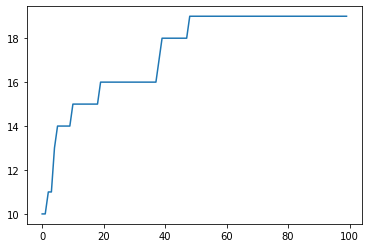

In [16]:
import matplotlib.pyplot as plt

q = {0: 10, 1: 10, 2: 11, 3: 11, 4: 13, 5: 14, 6: 14, 7: 14, 8: 14, 9: 14, 10: 15, 11: 15, 12: 15, 13: 15, 14: 15, 15: 15, 16: 15, 17: 15, 18: 15, 19: 16, 20: 16, 21: 16, 22: 16, 23: 16, 24: 16, 25: 16, 26: 16, 27: 16, 28: 16, 29: 16, 30: 16, 31: 16, 32: 16, 33: 16, 34: 16, 35: 16, 36: 16, 37: 16, 38: 17, 39: 18, 40: 18, 41: 18, 42: 18, 43: 18, 44: 18, 45: 18, 46: 18, 47: 18, 48: 19, 49: 19, 50: 19, 51: 19, 52: 19, 53: 19, 54: 19, 55: 19, 56: 19, 57: 19, 58: 19, 59: 19, 60: 19, 61: 19, 62: 19, 63: 19, 64: 19, 65: 19, 66: 19, 67: 19, 68: 19, 69: 19, 70: 19, 71: 19, 72: 19, 73: 19, 74: 19, 75: 19, 76: 19, 77: 19, 78: 19, 79: 19, 80: 19, 81: 19, 82: 19, 83: 19, 84: 19, 85: 19, 86: 19, 87: 19, 88: 19, 89: 19, 90: 19, 91: 19, 92: 19, 93: 19, 94: 19, 95: 19, 96: 19, 97: 19, 98: 19, 99: 19}

plt.plot(list(q.keys()), list(q.values()))

In [7]:
from abc import ABC, abstractmethod

class Infectable(ABC):
    def __init__(self, strength=1.0, contag=1.0):
        # contag is for contagiousness so we have less typos
        self.strength = strength
        self.contag = contag

    @abstractmethod
    def cause_symptoms(self, person):
        pass
    
    
class SeasonalFluVirus(Infectable):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name= 'SeasonalFluVirus'

    def cause_symptoms(self, person):
        person.temperature += 0.25

    def get_type(self):
        return InfectableType.SeasonalFlu

In [10]:
x = SeasonalFluVirus(strength=5)
x.strength

5

In [14]:
from abc import ABC, abstractmethod

class Person(ABC):
    MAX_TEMPERATURE_TO_SURVIVE = 44.0
    LOWEST_WATER_PCT_TO_SURVIVE = 0.4
    
    LIFE_THREATENING_TEMPERATURE = 40.0
    LIFE_THREATENING_WATER_PCT = 0.5
    
    def __init__(self, home_position=(0, 0), age=30, weight=70, virus=None, name=None):
        self.name = name
        self.age = age
        self.weight = weight
        self.temperature = 36.6
        self.water = 0.6 * self.weight
        self.virus = virus
        self.antibody_types = set()
        self.home_position = home_position
        self.position = home_position
#         self.state = Healthy(self)
    
    @abstractmethod
    def day_actions(self): pass

    @abstractmethod
    def night_actions(self): pass

    @abstractmethod
    def interact(self, other): pass

    @abstractmethod
    def get_infected(self, virus): pass
    
    def is_contacting(self, other):
        return self.position == other.position
    
    @abstractmethod
    def fight_virus(self): pass

    @abstractmethod
    def progress_disease(self): pass

    @abstractmethod
    def set_state(self, state): pass
    
    def is_life_threatening_condition(self):
        return self.temperature >= Person.LIFE_THREATENING_TEMPERATURE or \
           self.water / self.weight <= Person.LIFE_THREATENING_WATER_PCT
    
    def is_life_incompatible_condition(self):        
        return self.temperature >= Person.MAX_TEMPERATURE_TO_SURVIVE or \
            self.water / self.weight <= Person.LOWEST_WATER_PCT_TO_SURVIVE


class DefaultPerson(Person):
    
    def day_actions(self):
        self.state.day_actions()

    def night_actions(self):
        self.state.night_actions()

    def interact(self, other):
        self.state.interact(other)

    def get_infected(self, virus):
        self.state.get_infected(virus)
    
    def is_contacting(self, other):
        return self.position == other.position
    
    def fight_virus(self):
        if self.virus:
            self.virus.strength -= (3.0 / self.age)
        
    def progress_disease(self):
        if self.virus:
            self.virus.cause_symptoms(self)

    def set_state(self, state):
        self.state = state

class CommunityPerson(Person):

    def __init__(self, community_position=(0, 0), **kwargs):
        super().__init__(**kwargs)
        self.community_position = community_position
    
    def day_actions(self):
        self.state.day_actions()

    def night_actions(self):
        self.state.night_actions()

    def interact(self, other):
        self.state.interact(other)

    def get_infected(self, virus):
        self.state.get_infected(virus)
    
    def is_contacting(self, other):
        return self.position == other.position
    
    def fight_virus(self):
        if self.virus:
            self.virus.strength -= (3.0 / self.age)
        
    def progress_disease(self):
        if self.virus:
            self.virus.cause_symptoms(self)

    def set_state(self, state):
        self.state = state


In [15]:
x = DefaultPerson()

In [17]:
type(x)

__main__.DefaultPerson

In [19]:
isinstance(x, DefaultPerson)

True